### Установка пакетов

Начнем с установки необходимых пакетов python. Ничего необычного не понадобится - numpy, cv2, matplotlib

In [ ]:
# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib

Теперь можно импортировать

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from  random import randint
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

### Инициализация SLAM с использованием OpenCV (30 баллов)

Итак, мы снова находимся в сгенерированном мире c первой лекции. У нас был автомобиль, на котором были установлены сенсоры, выдающие нам карту глубин вместе с картинкой, а так же трансформацию (позу) в каждый момент времени. Теперь перейдем к более реальной ситуации: на нашей машине установлена только камера и ничего более (очень часто решается именно такая задача). Будем восстанавливать позу и глубины точек при помощи знаний, полученных на лекции (восстановление превой позы иногда называют инициализацией). Начнем с восстановления позы

Вам даны два изображения, вращение и перемещение между которыми мы хотим определить

In [2]:
def load_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

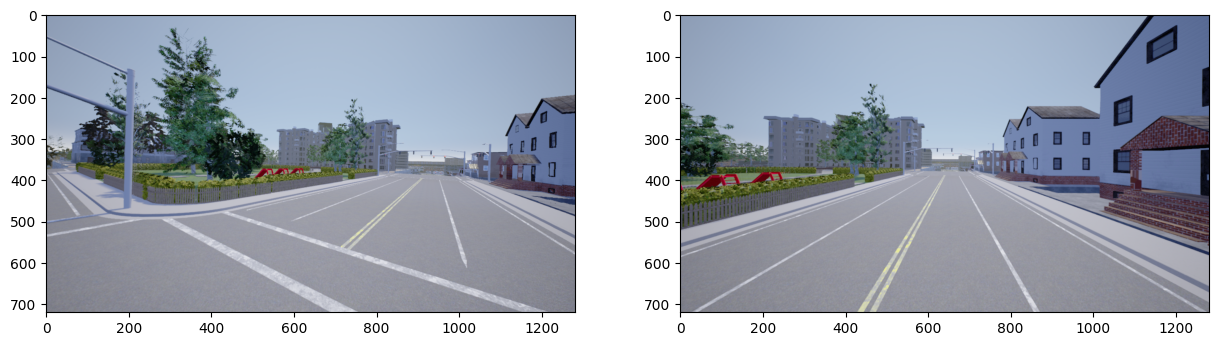

In [3]:
image1 = load_image("image1.png")
image2 = load_image("image2.png")
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image1)
axarr[1].imshow(image2)

Как мы узнали на лекции, первое, что нужно сделать для восстановления позы - найти особые точки (фичи) на обоих изображениях и соответствие между ними (сматчить). На второй лекции вы уже научились это делать, поэтому не будем сильно заострять на этом внимание: найдите фичи и матчи любым способом, который вам понравился ([здесь](https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html) можете найти пример с SIFT фичами)

In [ ]:
# ... Создайте детектер/матчер, найдите фичи, сматчите их, выделите лучшие
# В итоге мы хотим получить
pts1 = ... # Numpy матрица Nx2 - координаты фич на левом изображении
pts2 = ... # Numpy матрица Nx2 - координаты фич на правом изображении

Визуализируем наши матчи

In [ ]:
def draw_matches(image_a: np.ndarray, image_b: np.ndarray, keypoints_a: np.ndarray, keypoints_b: np.ndarray):
    # initialize the output visualization image
    height_a, width_a = image_a.shape[:2]
    height_b, width_b = image_b.shape[:2]

    vis = np.zeros((max(height_a, height_b), width_a + width_b, 3), dtype="uint8")
    vis[0:height_a, 0:width_a] = image_a
    vis[0:height_b, width_a:] = image_b

    # loop over the matches
    for keypoint_a, keypoint_b in zip(keypoints_a, keypoints_b):
        # draw the match
        point_a = (int(keypoint_a[0]), int(keypoint_a[1]))
        point_b = (
            int(keypoint_b[0]) + width_a,
            int(keypoint_b[1]),
        )
        cv2.line(vis,
                 point_a,
                 point_b,
                 (randint(0, 255), randint(0, 255), randint(0, 255)), 1)

    # return the visualization
    return vis

In [ ]:
img3 = draw_matches(image1, image2, pts1, pts2)
plt.imshow(img3),plt.show()

Итак, у нас есть матчи. Начнем с простого - воспользуемся встроенной функцией в OpenCV для определения существенной матрицы. Смотрите референс [здесь](https://amroamroamro.github.io/mexopencv/matlab/cv.findEssentialMat.html). Вам нужно правильно определить матрицу камеры и передать точки с левого и правого изображения.

In [ ]:
fx = 448.1551643293023
fy = 448.1551643293023
px = 640.0
py = 360.0

K = np.array(...) # TODO: заполните матрицу камеры
E, mask = # TODO: получите существенную матрицу

Отлично, у нас есть существенная матрица E, а также некторая маска mask. Это маска показывает, какие из матчей у нас соответствуют полученной матрице (inliers), а какие нет (outliers).

In [ ]:
pts1_inliers = ... # Numpy матрица Mx2 - координаты инлайеров на левом изображении
pts2_inliers = ... # Numpy матрица Mx2 - координаты инлайеров на правом изображении

Визуализиреум инлайеры и посмотрим, какой процент точек оказался инлайерами. Чем процент больше, тем лучше был наш матчер. Нормально, если он будет около 50%.

In [ ]:
print(f"Процент инлайеров: {pts1_inliers.shape[0] / pts1.shape[0] * 100}%")

img3 = draw_matches(image1, image2, pts1, pts2)
plt.imshow(img3),plt.show()

Если визуально корреспонденсы между изображениями выглядят адекватно, то самое время восстанавливать позу из существенной матрицы. Сейчас воспользуемся для этого внутренней функцией OpenCV - recoverPose. Не забудьте использовать для это только инлайеры!

In [ ]:
numOfInliers, R_opencv, t_opencv, mask = ... # Воостановите позу из E с помощью recoverPose

Отлично, у нас есть оцененные R и t. Самое время сравнить его с ground truth (gt), который нам был дан в первом задании. Есть один нюанс: на лекции мы узнали, что из алгоритмов такого рода нельзя восстановить скейл сцены, поэтому перед сравнением t_gt нужно нормализовать.

In [ ]:
R_gt = np.array([[8.50318515e-01, 2.07742095e-02, -5.25858208e-01],
              [-2.47312245e-02, 9.99694013e-01, -4.97406376e-04],
              [5.25686969e-01, 1.34280713e-02, 8.50572100e-01]])
t_gt = np.array([[6.51715996e-01, 6.20712517e-03, -6.44666629e+00]]).transpose()
scale = np.linalg.norm(t_gt)
t_gt /= scale

print(f"Ошибка в матрице вращения: {np.linalg.norm(R_gt - R_opencv) / np.linalg.norm(R_gt) * 100}%")
print(f"Ошибка в перемещении: {np.linalg.norm(t_gt - t_opencv) / np.linalg.norm(t_gt) * 100}%")

Ошибиться на 1% во вращении и на 3% в перемещении - это нормально, хороший результат.

И последний этап с использованием готовых функций: восстановим глубины фич. Для этого нужно воспользоваться функцией triangulatePoints из библиотеки OpenCV. У нее чуть более хитрые входные данные, составим их поэтапно. Подумайте над тем, какую именно позу мы нашли (R_opencv, t_opencv), и какие позы у первого и второго изображения.

In [ ]:
projection_matrix_1 = ... # проективная матрица для первого изображения. Напоминаем, что проективная матрица это
                          # CameraMatrix @ np.eye(3, 4) @ PoseMatrix4x4
projection_matrix_2 = ... # проективная матрица для второго изображения. Напоминаем, что проективная матрица это
                          # CameraMatrix @ np.eye(3, 4) @ PoseMatrix4x4
points_3d_hom = ... # триангулируйте точки с помощью triangulatePoints. Это будут 3D точки в однородных координатах
points_3d = ... # превратите 3D из однородных координат в обычные
depth_opencv = ... # получите глубины из данных 3D точек. Это делжен быть вектор длиной M (количество инлайеров).

Самое время загрузить глубины, которые были даны в первом ДЗ и сравнить с полученными. Опять же, не забудьте, что глубины точек метрические, а значит зависят от скейла. Мы уже зафиксировали скейл для gt, поэтому воспользуемся им.

In [ ]:
# Загрузим gt глубины, нормируем их
depth_gt_full = np.load("depth1.npy") * 1000 / scale
# Выделим gt глубины только для фич
depth_gt = depth_gt_full[pts1_inliers[:, 1].astype(int), pts1_inliers[:, 0].astype(int)].squeeze()

# Посчитаем среднюю ошибку. Не будем учитывать слишком далекие точки
errors = []
for i, d_gt in enumerate(depth_gt):
    if d_gt < 100 / scale:
        print(d_gt, depth_opencv[i])
        errors.append(abs(d_gt - depth_opencv[i]) / max(d_gt, depth_opencv[i]) * 100)

print(f"Средняя ошибка в определении глубин: {sum(errors) / len(errors)}%")

Отлично, ошибиться на 10% в определении глубин - это нормально, на это влияет много факторов.

Итак мы продедади полную инициализацию SLAM - нашли матчи, посчитали существенную матрицу, восстановили позу и глубины. На этом задача заверщается и далее предлалагается продлелать те же вещи, но написать все алгоритмы самостоятельно

### Инициализация SLAM с использованием самописных методов (20 баллов)

Начнем опять с восстановления существенной матрицы. Не забудьте, что на вход мы подаем изначальные точки, pts1 и pts2

In [ ]:
def findEssentialMatrix8pt(pts1_8pt, pts2_8pt, K):
    ... # В данный функции реализуйте 8 points алгоритм для определения существенной матрицы
        # В качестве сингулярных чисел используйте сразу [1, 1, 0]

def findEssentialMatrixRansac(pts1, pts2,
                              K,
                              samples=2000, threshold=0.001):
    ... # В данный функции реализуйте RANSAC, который будет случайно выбирать 8 точек, определять по ним E,
        # считать, сколько инлайеров соответствет данной модели (инлайер - та пара, у которой epipolar constraint
        # меньше threshold). И так samples раз. Верните E, у которой максимальное количество инлайеров. Так
        # же верните маску mask, как \то делает OpenCV

Воспользуйтесь новой функцией, определите существенную матрицу и вновь определите инлайеры

In [ ]:
E_est, mask_est = findEssentialMatrixRansac(pts1, pts2, K)
pts1_inliers = ... # Numpy матрица Mx2 - координаты инлайеров на левом изображении
pts2_inliers = ... # Numpy матрица Mx2 - координаты инлайеров на правом изображении

Сравните визульно E (определена с помощью OpenCV) и E_est (определена вручную). Если есть небольшие отличия - это не страшно, иметь смысл будет только восстановленная поза.

In [ ]:
print("OpenCV существенная матрица")
print(E)
print("Custom существенная матрица")
print(E_est)

Далее напишите кастомную функцию для восстановления позы из существенной матрицы

In [ ]:
def recoverPose(E, pts1, pts2, K):
    ... # Восстановите позу из E. Из 4х гипотез выберите ту, у которой точек перед камерой больше всего.
        # Считайте, что перед камерой - это значит глубина > 1
        # Верните из этой функции R и t по отдельности

Воспользуйтесь новой функцией, восстановите позу и сравните ее с gt. Больше или меньше ошибка, по сравнении с методом из OpenCV?

In [ ]:
R_custom, t_custom = recoverPose(E_est, pts1_inliers, pts2_inliers, K)

print(f"Ошибка в матрице вращения: {np.linalg.norm(R_gt - R_custom) / np.linalg.norm(R_gt) * 100}%")
print(f"Ошибка в перемещении: {np.linalg.norm(t_gt - t_custom) / np.linalg.norm(t_gt) * 100}%")

In [ ]:
def triangulatePoints(pts1, pts2, R, t, K):
    ... # Реализуйте триангуляцию, аналогичную OpenCV.
        # Не надо заморачиваться с 3D точками - возвращайте сразу вектор Mx1, где M - количество точек на входе


Зделаем аналогичноное сравнение с gt. Опять же, ошибаться в пределе 10-20% - это хороший результат.

In [ ]:
depth_custom = triangulatePoints(
    pts1_inliers,
    pts2_inliers,
    R_custom, t_custom, K
)

# Выделим gt глубины только для фич
depth_gt = depth_gt_full[pts1_inliers[:, 1].astype(int), pts1_inliers[:, 0].astype(int)].squeeze()

errors = []
for i, d_gt in enumerate(depth_gt):
    if d_gt < 100 / scale:
        errors.append(abs(d_gt - depth_custom[i]) / max(d_gt, depth_custom[i]) * 100)

print(f"Средняя ошибка в определении глубин: {sum(errors) / len(errors)}")